In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style = 'white', font_scale=1.5)

from umap import UMAP

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

In [2]:
df_study_tpm = pd.read_excel('./model_data/v2.tpm.xlsx', index_col=0)
df_study_sample = pd.read_excel('./model_data/v2.samples.xlsx', index_col=0)

In [4]:
df_tcga_tpm = pd.read_pickle('/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37/df8.pkl')
tcga_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37'
df_tcga_mut = pd.read_pickle(os.path.join(tcga_data_path, 'df_patient_mut.pkl'))
spm = list(set(df_tcga_mut.index) & set(df_tcga_tpm.index))

df_tcga_tpm = df_tcga_tpm.loc[spm]
df_tcga_mut = df_tcga_mut.loc[spm]
df_tcga_mut.shape

(8971, 11)

In [5]:
com_genes = list(set(df_study_tpm.index) & set(df_tcga_tpm.columns[1:]))
df_study_tpm = df_study_tpm.loc[com_genes]
df_tcga_tpm = df_tcga_tpm[com_genes].T

In [6]:
df_tcga_tpm = df_tcga_tpm.loc[com_genes]
df_study_tpm = df_study_tpm.loc[com_genes]

In [7]:
dfm = df_tcga_tpm.join(df_study_tpm).round(2)
dfm = dfm.T
dfm.shape

(9305, 16570)

In [8]:
dfg1 = df_tcga_mut[['cancer_type', 'tmb_wang','tmb_dan']]
dfg1['cohort'] = 'TCGA'
dfg1.cancer_type = dfg1.cancer_type.apply(lambda x:x.split('-')[1])
dfg2 = df_study_sample[['cohort', 'tmb.wang','tmb.dan']].rename(columns={'tmb.wang':'tmb_wang', 'tmb.dan':'tmb_dan'})
dfg2['cancer_type'] = 'SKCM'
dfg = pd.concat([dfg1, dfg2])

/tmp/ipykernel_14152/1078287150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg1['cohort'] = 'TCGA'
/tmp/ipykernel_14152/1078287150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg1.cancer_type = dfg1.cancer_type.apply(lambda x:x.split('-')[1])


In [9]:
dfs = dfm.join(dfg)

In [10]:
dfs[dfs.cancer_type == 'SKCM'].groupby('cohort').size().sort_values()

cohort
Hugo          26
MGH           38
Van Allen     39
Riaz          51
Gide          73
TCGA         103
Liu          107
dtype: int64

In [11]:
ogens = dfm.columns
def _sel_genes(x):
    var = x[ogens].var(axis=0) 
    sel_genes = var[var > 2].index
    return sel_genes

In [12]:
sgenes = dfs[dfs.cancer_type == 'SKCM'].groupby('cohort').apply(lambda x:_sel_genes(x).tolist()).tolist()
sgenes = list(set.intersection(*map(set, sgenes)))

print(len(sgenes))

dfm1 = dfm[sgenes]
dfm1 = np.log2(dfm1+1)
dfs1 = dfm1.join(dfg)

9674


In [13]:
skcm = dfs1[dfs1.cancer_type == 'SKCM']

Text(0, 0.5, 'UMAP2')

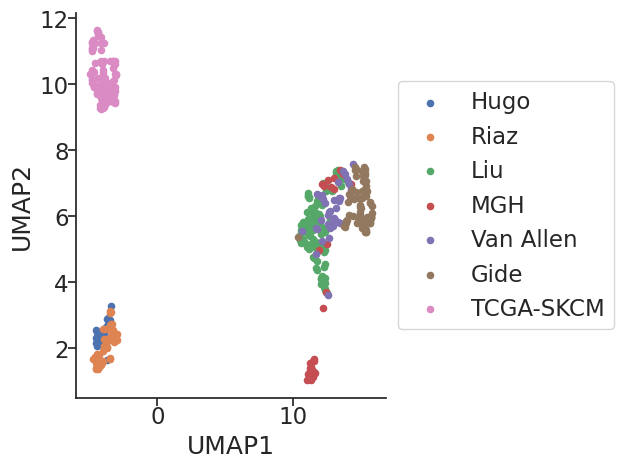

In [14]:
mp = UMAP(random_state=123, metric='correlation')
skcm_genes_2d = mp.fit_transform(skcm[sgenes])

dfp_skcm = pd.DataFrame(skcm_genes_2d, columns=['x', 'y'],index=skcm.index)
dfp_skcm = dfp_skcm.join(skcm[skcm.columns[-4:]])

fig, ax = plt.subplots(figsize=(4,5))
cohorts = [ 'Hugo','Riaz', 'Liu', 'MGH', 'Van Allen', 'Gide', 'TCGA', ]
for bt in cohorts:
    dfp1 = dfp_skcm[dfp_skcm.cohort == bt]
    if bt == 'TCGA':
        bt = 'TCGA-SKCM'
    ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

Text(0, 0.5, 'UMAP2')

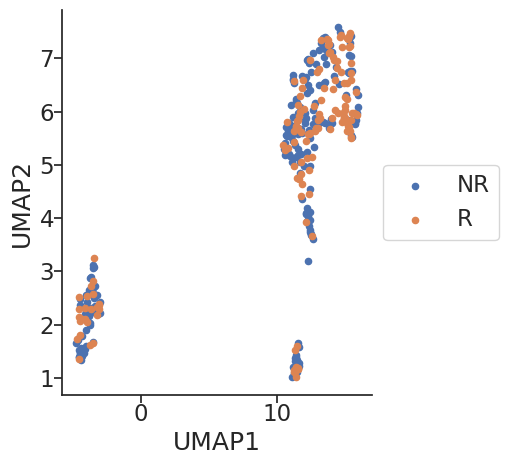

In [15]:
mp = UMAP(random_state=123, metric='correlation')
skcm_genes_2d = mp.fit_transform(skcm[sgenes])

dfp_skcm = pd.DataFrame(skcm_genes_2d, columns=['x', 'y'],index=skcm.index)
dfp_skcm = dfp_skcm.join(skcm[skcm.columns[-4:]])

dfp_skcm = dfp_skcm.join(df_study_sample['Freeman_response'].to_frame(name='flag'))
dfp_skcm = dfp_skcm[~dfp_skcm.flag.isna()]


fig, ax = plt.subplots(figsize=(4,5))
cohorts = [ 'Hugo','Riaz', 'Liu', 'MGH', 'Allen', 'Gide', 'TCGA', ]
for bt in dfp_skcm.flag.unique():
    dfp1 = dfp_skcm[dfp_skcm.flag == bt]

    ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

Text(0, 0.5, 'UMAP2')

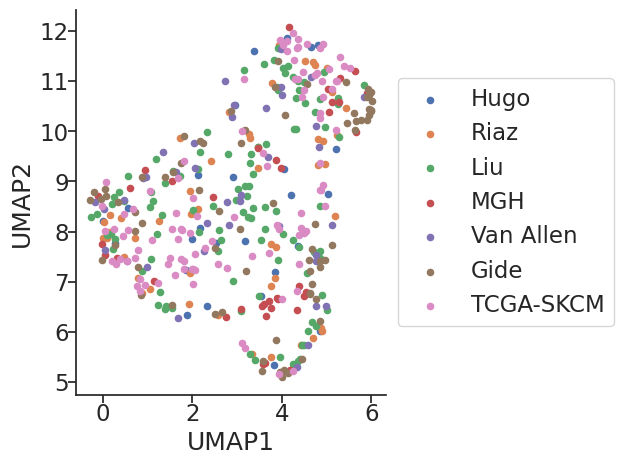

In [16]:
def convert2fp(x):
    sg = skcm.columns[:-4]
    x = x[sg]
    tertile_thres = x.quantile(1/3)
    x_new = x.apply(lambda i: i.gt(tertile_thres), axis=1)*1.0
    return x_new
    
skcm_new = skcm.groupby('cohort').apply(convert2fp).reset_index().set_index('level_1')
skcm_new = skcm_new.loc[skcm.index]

mp = UMAP(random_state=123, metric='correlation')
skcm_genes_2d = mp.fit_transform(skcm_new[sgenes])

dfp_skcm = pd.DataFrame(skcm_genes_2d, columns=['x', 'y'],index=skcm.index)
dfp_skcm = dfp_skcm.join(skcm[skcm.columns[-4:]])

fig, ax = plt.subplots(figsize=(4,5))
cohorts = [ 'Hugo','Riaz', 'Liu', 'MGH', 'Van Allen', 'Gide', 'TCGA', ]
for bt in cohorts:
    dfp1 = dfp_skcm[dfp_skcm.cohort == bt]
    if bt == 'TCGA':
        bt = 'TCGA-SKCM'
    ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

In [17]:
dfg

,cancer_type,tmb_wang,tmb_dan,cohort
TCGA-BK-A6W4,UCEC,-1.161888,-0.913960,TCGA
TCGA-CJ-5689,KIRC,0.860480,1.123515,TCGA
TCGA-HD-8224,HNSC,0.745003,0.904202,TCGA
TCGA-DJ-A13P,THCA,-3.161888,-2.839960,TCGA
TCGA-06-0125,GBM,1.803897,1.987859,TCGA
...,...,...,...,...
7_PD1_PRE,SKCM,NaN,NaN,Gide
7_ipiPD1_PRE,SKCM,NaN,NaN,Gide
8_PD1_PRE,SKCM,NaN,NaN,Gide
8_ipiPD1_PRE,SKCM,NaN,NaN,Gide


Text(0, 0.5, 'UMAP2')

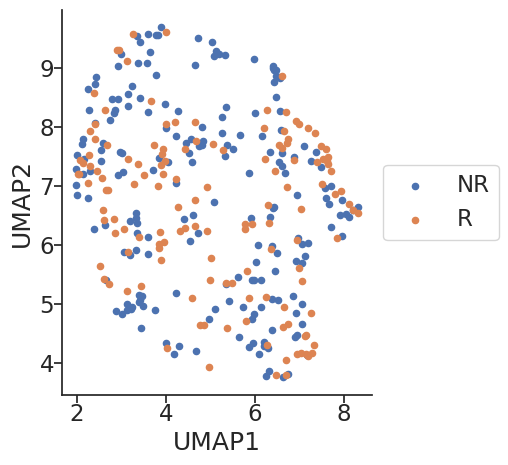

In [18]:
def convert2fp(x):
    sg = skcm.columns[:-4]
    x = x[sg]
    tertile_thres = x.quantile(1/2)
    x_new = x.apply(lambda i: i.gt(tertile_thres), axis=1)*1.0
    return x_new
    
skcm_new = skcm.groupby('cohort').apply(convert2fp).reset_index().set_index('level_1')
skcm_new = skcm_new.loc[skcm.index]

mp = UMAP(random_state=123, metric='correlation')
skcm_genes_2d = mp.fit_transform(skcm_new[sgenes])

dfp_skcm = pd.DataFrame(skcm_genes_2d, columns=['x', 'y'],index=skcm.index)
dfp_skcm = dfp_skcm.join(skcm[skcm.columns[-4:]])


dfp_skcm = dfp_skcm.join(df_study_sample['Freeman_response'].to_frame(name='flag'))
dfp_skcm = dfp_skcm[~dfp_skcm.flag.isna()]
# dfp_skcm.flag = dfp_skcm.flag.map({1:'responder', 0:'non-responder',2:'unknow'})


fig, ax = plt.subplots(figsize=(4,5))
cohorts = [ 'Hugo','Riaz', 'Liu', 'MGH', 'Allen', 'Gide', 'TCGA', ]
for bt in dfp_skcm.flag.unique():
    dfp1 = dfp_skcm[dfp_skcm.flag == bt]

    ax.scatter(dfp1.x, dfp1.y, label = bt, s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

In [19]:
ls

00_process_all.ipynb    Freeman_raw/       Liu_clinical.csv  Riaz_clinical.csv
01_plot_batch.v2.ipynb  Gide_clinical.csv  Liu_raw/          Riaz_raw/
02_combine_all.ipynb    Gide_raw/          MGH_clinical.csv  Untitled.ipynb
Allen_clinical.csv      Hugo_clinical.csv  MGH_raw/
Allen_raw/              Hugo_raw/          model_data/
